In [2]:
#import data
import pandas as pd

heart = pd.read_csv("./data/heart.csv")

In [3]:
heart.head()  #all numeric values, output is the target value which is categorical with a 0 (no risk) or a 1 (risk)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
heart.info() #no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
heart.describe() #scales are different, will require feature scaling

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


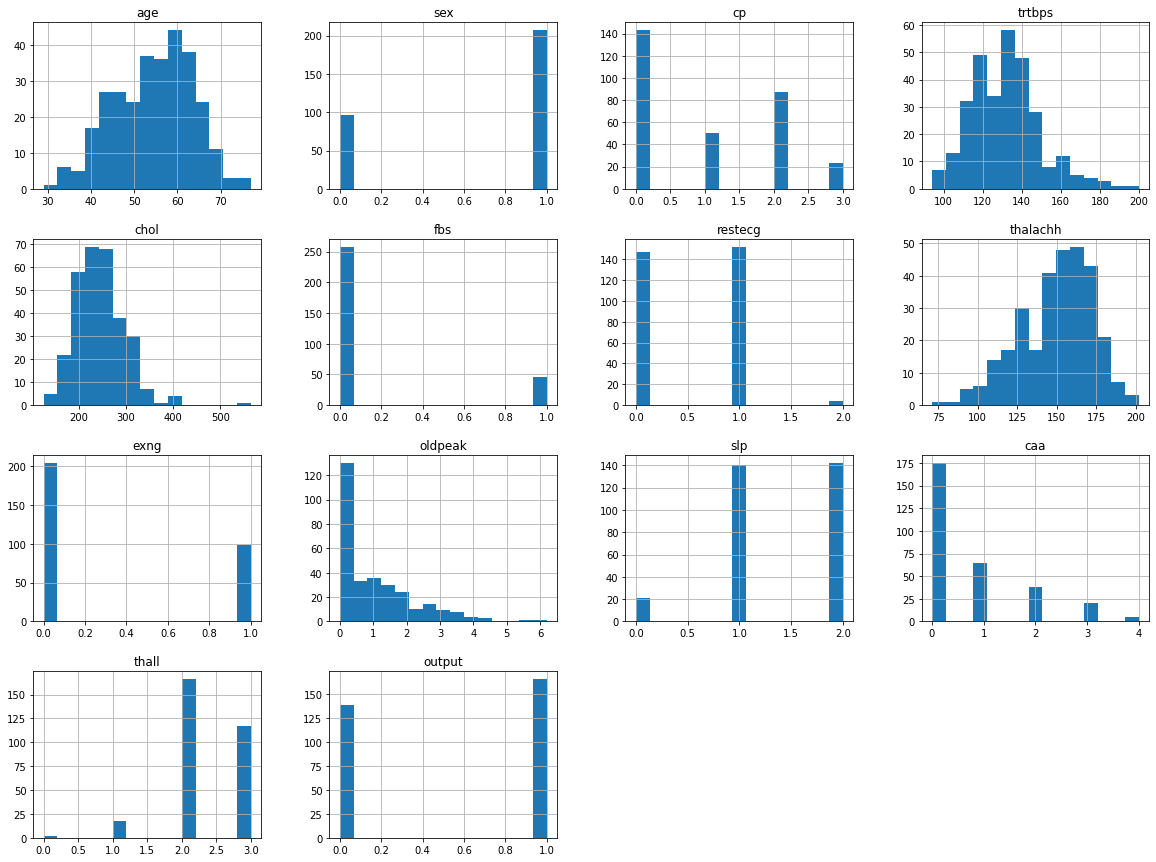

In [6]:
#visualize all features to see distributions
%matplotlib inline
import matplotlib.pyplot as plt
heart.hist(bins=15, figsize=(20,15)) #figsize = (width, height)
plt.show()

In [17]:
#split data into test and training sets
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(heart,                       #data frame to split
                                       test_size=0.2,                 #size of test set (proportion)
                                       random_state=42)               #ensures reproducibility

heart = train_set.copy()

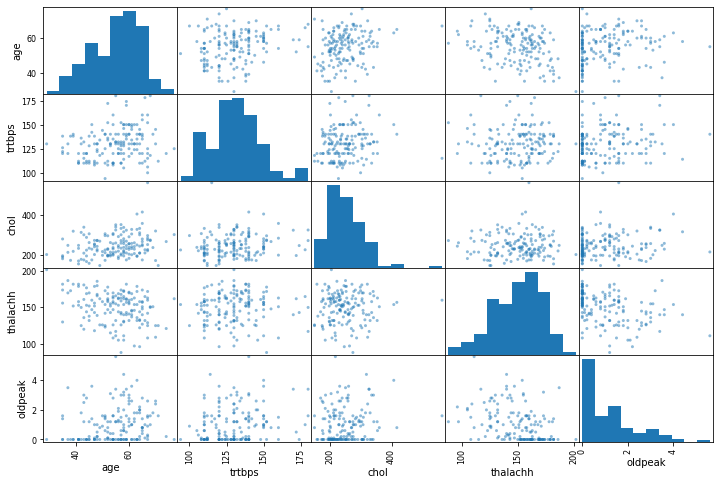

In [18]:
#can also create a scatter matrix to visualize all correlations at once
from pandas.plotting import scatter_matrix

attributes = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
scatter_matrix(heart[attributes], figsize=(12, 8))
plt.show()

In [20]:
#see if htere is a correlation
corr_matrix = heart[attributes].corr()
corr_matrix["age"].sort_values(ascending=False)
print(corr_matrix["chol"].sort_values(ascending=False))
print(corr_matrix["trtbps"].sort_values(ascending=False))
print(corr_matrix["oldpeak"].sort_values(ascending=False))
print(corr_matrix["thalachh"].sort_values(ascending=False))

chol        1.000000
age         0.256842
trtbps      0.138852
oldpeak     0.124895
thalachh    0.024456
Name: chol, dtype: float64
trtbps      1.000000
age         0.211079
oldpeak     0.182245
chol        0.138852
thalachh    0.022227
Name: trtbps, dtype: float64
oldpeak     1.000000
age         0.184043
trtbps      0.182245
chol        0.124895
thalachh   -0.377307
Name: oldpeak, dtype: float64
thalachh    1.000000
chol        0.024456
trtbps      0.022227
age        -0.301438
oldpeak    -0.377307
Name: thalachh, dtype: float64
